In [8]:
import numpy as np
import matplotlib.pyplot as plt 
rng = np.random.default_rng(12345)
from dadapy.id_discrete import IdDiscrete
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test on uniform distribution

1. create the dataset

In [9]:
N = 2500
box = 50
d = 5
data = rng.integers(0,box,size=(N, d))

2. load into the estimator and compute distances:
    1. use condensed=False, to store point-point distances. This option is useful to trace WHICH are the neighbours, but can be memory demanding, as in principle the information is stored in to an NxN matrix (or N x maxk, i.e. truncated at the maxk neighbour). Generally one wants to store a matrix which is 10^8 at most. This routines use the canonical NearestNeighbour routine from the sklearn library.

In [10]:
%%time
I3D = IdDiscrete(data, condensed=False, maxk=data.shape[0]-1)
# use Periodic Boundary Conditions, if it makes sense, through the flag 'period'. If that's not the case, simply remove the flag
I3D.compute_distances(metric='manhattan',period=box)

CPU times: user 992 ms, sys: 48.7 ms, total: 1.04 s
Wall time: 1.04 s


In order to have an idea of the mean distances between points, one looks at I3D.distances 

In [11]:
print('mean distance of first neighbour: ',I3D.distances[:,1].mean())
print('mean distance of second neighbour: ',I3D.distances[:,2].mean())

mean distance of first neighbour:  12.3116
mean distance of second neighbour:  14.8772


2. load into the estimator and store distances more efficiently:
    2. by condensed=True, one stores the cumulative of how many points there are within a given distance. One deals with a N x d_max matrix that stores all information if d_max is the maximum possible distance between two points of the dataset. It is recommended to set condensed=True for datasets bigger than 30k points. This is performed through a cython function that can run in parallel.
    

In [12]:
%%time
I3Dc = IdDiscrete(data, condensed=True, maxk=data.shape[0])
# once again, use Periodic Boundary Conditions, if it makes sense, through the flag 'period'
I3Dc.compute_distances(metric='manhattan',d_max=box*d,period=box)

N.B. the data will be passed to the routine to compute distances as integers
CPU times: user 795 ms, sys: 27.4 ms, total: 822 ms
Wall time: 57.8 ms


In [13]:
dist_1NN = np.mean([np.where(dd>1)[0][0] for dd in I3Dc.distances])
print('mean distance of first neighbour: ',dist_1NN)
dist_2NN = np.mean([np.where(dd>2)[0][0] for dd in I3Dc.distances])
print('mean distance of first neighbour: ',dist_2NN)

mean distance of first neighbour:  12.3116
mean distance of first neighbour:  14.8772


3. By using the function compute_id_binomial_k one computes the id taking into account the first k neighbours for each point. The function returns the ID estimate, the error and the scale. Check consistency between the two ways distances are stored

In [62]:
%%time
I3D.compute_id_binomial_k(20,False,0.5)

CPU times: user 4.99 s, sys: 0 ns, total: 4.99 s
Wall time: 5 s


(4.938174408662373, 0.037584115772826, 23.636)

In [63]:
%%time
I3Dc.compute_id_binomial_k(20,False,0.5)

CPU times: user 4.87 s, sys: 0 ns, total: 4.87 s
Wall time: 4.86 s


(4.938174408662373, 0.037584115772826, 23.636)

3. 
    1. In order to check the distance of the k-th neighbour one can access the instance lk of the class

In [64]:
print(I3D.lk)
print(I3D.lk.mean())

[23. 25. 24. ... 23. 24. 24.]
23.636


4. Once you have an idea of the scales at which points are placed, one can compute the ID at a precise, physical and meaningful scale by fixing the radii of the two shells used for the comparison (see [1]). The function returns the ID, its error and the scale. One can choose between a maximum likelihood estimation, setting method='mle', or a bayesian approach, setting method='bayes'. The two basically give the same results if the number of point is greater than 100. Nonetheless, the bayesian approach returns the profile of the posterior if plot=True (but it is slower, as it has to compute the posterior in every points)

In [65]:
I3D.compute_id_binomial_lk(25,20,'mle'), I3Dc.compute_id_binomial_lk(25,20,'mle')

((5.0079049465555325, 0.02722028188438483, 25),
 (5.0079049465555325, 0.02722028188438483, 25))

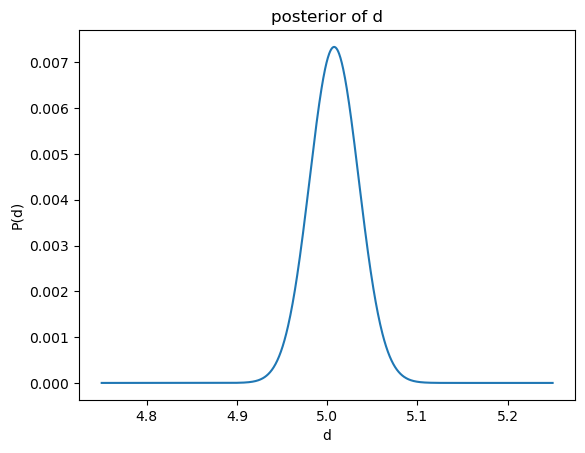

empirical average:	 5.007910183342587 
empirical std:		 0.027219995054375196


(5.007910183342587, 0.027219995054375196, 25)

In [66]:
I3D.compute_id_binomial_lk(25,20,'bayes',plot=True)

4. 
    1. In order to check how many neighbours were taken into account, one can access the instance k of the class

In [13]:
print(I3D.k)
print(I3D.k.mean())

[28 17 22 ... 28 23 22]
24.14


5. One can check the goodness of the estimate using two quantities: 
    1. the comparison of local density of points within the inner radius and the density of points in the shell between the two radii. In particular one wish to obsercve the points staying as close as possible to the 

average distance from line:  0.22381416196522105


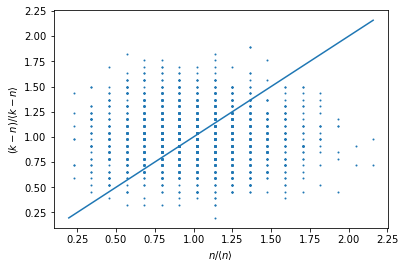

In [14]:
I3D.compute_local_density();

5. and
    2. the Kolmogorov-Smirnoff test between the theoretical and the empirical distributions of points n, within the inner shell. The higher the overlap, the more reliable is the id estimate as the model is capable of grasping the distribution of points. The function returns the p-value.
    In general, for small raddi the KS gives good results as the density is really locally constant.

ks_stat:	0.0108
p-value:	0.9986185536971761


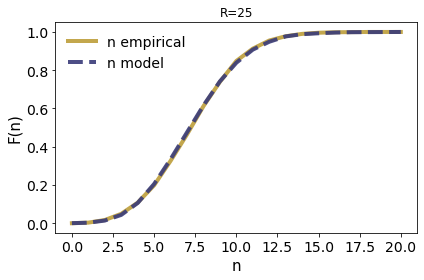

0.9986185536971761

In [15]:
I3D.model_validation_full()

6. the scaling (id as a function of the distance) can be obtained using the function return_id_scaling, setting the range of distances and the ratio between the shells (0.5 by default, get closer to 1 if the id ~ 10)

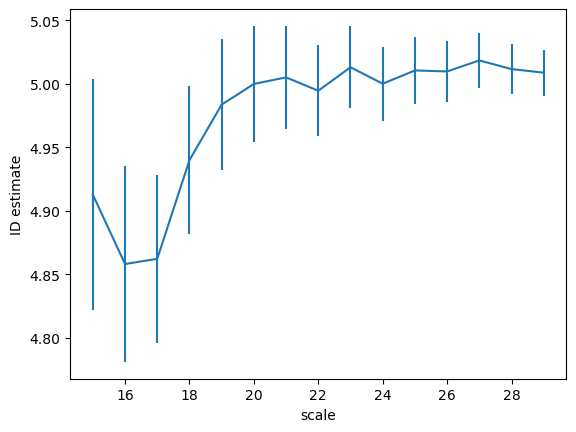

CPU times: user 614 ms, sys: 116 ms, total: 730 ms
Wall time: 521 ms


In [67]:
%%time
ids, id_er = I3D.return_id_scaling(range(15,30),0.75)

7. One can perform the estimate using only a subset of point by simply adding subset=your_index_list at the various compute/return_id functions (you can also provide an integer number, a random subsample of that size will be used)

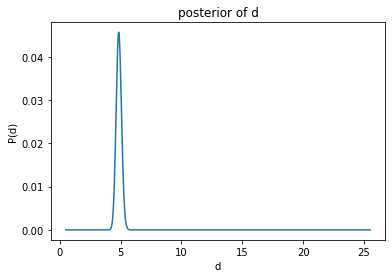

empirical average:	 4.85991798780265 
empirical std:		 0.2190030751795338


(4.85991798780265, 0.2190030751795338, 20)

In [18]:
I3D.compute_id_binomial_lk(20,15,subset=np.arange(100))